In [1]:
import numpy as np
import pandas as pd
import optuna
import pickle
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor, plot_importance
from mlforecast import MLForecast
from sklearn.metrics import mean_absolute_percentage_error

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
train_df = pd.read_csv("../output/0_data_cleaning/lightgbm/lag1/train_lightgbm.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})
test_df = pd.read_csv("../output/0_data_cleaning/lightgbm/lag1/test_lightgbm.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})

In [3]:
train_df

,year,country,population,gdp,temperature_change_from_co2,cement_co2_lag_1,coal_co2_lag_1,flaring_co2_lag_1,gas_co2_lag_1,land_use_change_co2_lag_1,oil_co2_lag_1,co2
0,1929,Argentina,0.007041,0.007596,0.02649,0.000247,0.001689,0.000000,0.000253,0.189716,0.001601,0.057195
1,1930,Argentina,0.007256,0.007274,0.02649,0.000370,0.001696,0.000000,0.000390,0.190037,0.001654,0.050794
2,1931,Argentina,0.007455,0.006756,0.02649,0.000402,0.001655,0.000000,0.000386,0.170616,0.001586,0.046617
3,1932,Argentina,0.007637,0.006527,0.02649,0.000564,0.001416,0.000000,0.000480,0.157812,0.002007,0.044323
4,1933,Argentina,0.007800,0.006839,0.02649,0.000525,0.001291,0.000000,0.000655,0.150694,0.002278,0.042756
...,...,...,...,...,...,...,...,...,...,...,...,...
3139,2003,Vietnam,0.060122,0.025702,0.02649,0.017601,0.005604,0.013673,0.003490,0.148809,0.011342,0.055115
3140,2004,Vietnam,0.060755,0.027628,0.02649,0.019924,0.006518,0.016147,0.004431,0.157641,0.011685,0.057655
3141,2005,Vietnam,0.061385,0.029640,0.02649,0.021913,0.007093,0.015907,0.007456,0.160666,0.013424,0.052390
3142,2006,Vietnam,0.061999,0.031614,0.02649,0.025491,0.008044,0.015322,0.007996,0.141767,0.013411,0.050074


In [4]:
# Load the fitted DataScaler object
with open('../output/0_data_cleaning/lightgbm/lag1/data_preprocessor_lightgbm1.pkl', 'rb') as f:
    data_preprocessor_lightgbm = pickle.load(f)

In [24]:
# Count rows for each country in train and test datasets
train_country_counts = train_df['country'].value_counts().reset_index()
train_country_counts.columns = ['country', 'train_count']

test_country_counts = test_df['country'].value_counts().reset_index()
test_country_counts.columns = ['country', 'test_count']

# Merge the counts into a single DataFrame
country_counts_df = pd.merge(
    train_country_counts,
    test_country_counts,
    on='country',
    how='outer'  # Keeps all countries, even if they are only in train or test
).fillna(0)  # Fill missing counts with 0 if a country is missing in one dataset

# Ensure counts are integers
country_counts_df['train_count'] = country_counts_df['train_count'].astype(int)
country_counts_df['test_count'] = country_counts_df['test_count'].astype(int)

# Display the result
country_counts_df.sort_values(by=['train_count'], ascending=False)

,country,train_count,test_count
41,United States,136,35
23,Netherlands,136,35
16,Indonesia,106,27
21,Malaysia,97,25
43,Venezuela,94,24
35,Sweden,91,23
33,South Korea,88,23
8,Colombia,80,21
27,Philippines,75,19
1,Australia,75,19


In [6]:
def log_mape(y_true, y_pred):
    return np.mean(np.abs((np.log1p(y_true) - np.log1p(y_pred)) / np.log1p(y_true)))

In [7]:
# Define the Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30), #4/5-30
        'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 0.001, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 12), # 1-5
        'num_threads': trial.suggest_int('num_threads', 2, 8),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # 10-100
        #deal with overfitting
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),

        'verbosity': -1,

        'objective':'regression_l1',
        'metric':'mae',
        'is_unbalance':True,
    }

    # Initialize the model
    model_optuna = LGBMRegressor(**param)

    # Initialize MLForecast
    forecast_model_optuna = MLForecast(
        models=[model_optuna],
        freq=1,
        date_features=None,
        num_threads=2
    )

    # Perform cross-validation manually with dynamic horizons
    all_cv_predictions = []

    for country, country_data in train_df.groupby('country'):
        # Calculate the horizon dynamically
        horizon = max(1, int(0.10 * len(country_data)))

        # Perform cross-validation for this country
        cv_predictions = forecast_model_optuna.cross_validation(
            df=country_data,
            h=horizon,
            n_windows=2,
            step_size=horizon//2,
            id_col='country',
            time_col='year',
            target_col='co2',
            static_features=[]
        )

        # Add the country information to the predictions
        cv_predictions['country'] = country
        all_cv_predictions.append(cv_predictions)

    # Concatenate all predictions into a single DataFrame
    cv_predictions = pd.concat(all_cv_predictions).reset_index(drop=True)

    # Rename 'LGBMRegressor' to 'co2_predicted'
    cv_predictions = cv_predictions.rename(columns={'co2': 'co2_actual', 'LGBMRegressor': 'co2_predicted'})
    cv_predictions = cv_predictions.dropna(subset=['co2_actual', 'co2_predicted'])

    # Calculate MAPE
    mape = mean_absolute_percentage_error(cv_predictions['co2_actual'], cv_predictions['co2_predicted'])

    return mape
    # Calculate log-MAPE
    # log_mape_value = log_mape(cv_predictions['co2_actual'], cv_predictions['co2_predicted'])

    # return log_mape_value 

In [8]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-11-20 15:40:38,381] A new study created in memory with name: no-name-b36efa5b-3135-4df5-90dd-5855c6e80a93
[I 2024-11-20 15:40:43,854] Trial 0 finished with value: 0.14988315205402164 and parameters: {'learning_rate': 0.07168256991534691, 'num_leaves': 32, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 7, 'max_depth': 9, 'num_threads': 4, 'n_estimators': 758, 'bagging_fraction': 0.6833953998135182, 'feature_fraction': 0.8177672188234958, 'lambda_l1': 9.434313689855431, 'lambda_l2': 9.02558312923328}. Best is trial 0 with value: 0.14988315205402164.
[I 2024-11-20 15:40:57,394] Trial 1 finished with value: 0.11585566406647518 and parameters: {'learning_rate': 0.05972385059568522, 'num_leaves': 35, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 7, 'max_depth': 9, 'num_threads': 5, 'n_estimators': 913, 'bagging_fraction': 0.9003572301516994, 'feature_fraction': 0.958508292912037, 'lambda_l1': 3.173284503417203, 'lambda_l2': 4.7762626696370845}. Best is trial 1 with value: 0.11

Best Hyperparameters: {'learning_rate': 0.08835630945957013, 'num_leaves': 16, 'min_data_in_leaf': 1, 'min_sum_hessian_in_leaf': 4, 'max_depth': 11, 'num_threads': 6, 'n_estimators': 400, 'bagging_fraction': 0.7769200303284034, 'feature_fraction': 0.684010363643239, 'lambda_l1': 1.573518546371549, 'lambda_l2': 2.815688065075287}


In [9]:
best_params

{'learning_rate': 0.08835630945957013,
 'num_leaves': 16,
 'min_data_in_leaf': 1,
 'min_sum_hessian_in_leaf': 4,
 'max_depth': 11,
 'num_threads': 6,
 'n_estimators': 400,
 'bagging_fraction': 0.7769200303284034,
 'feature_fraction': 0.684010363643239,
 'lambda_l1': 1.573518546371549,
 'lambda_l2': 2.815688065075287}

In [10]:
# Initialize the model with best hyperparameters
best_model = LGBMRegressor(
    **best_params,
    verbosity=-1,

    objective= 'regression_l1',
    metric= 'mae',
    is_unbalance= False,
)

# Initialize MLForecast with the best model
forecast_model = MLForecast(
    models=[best_model],
    freq=1,
    date_features=None,
    num_threads=2
)

train_transformed = forecast_model.preprocess(
    df=train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[]
)

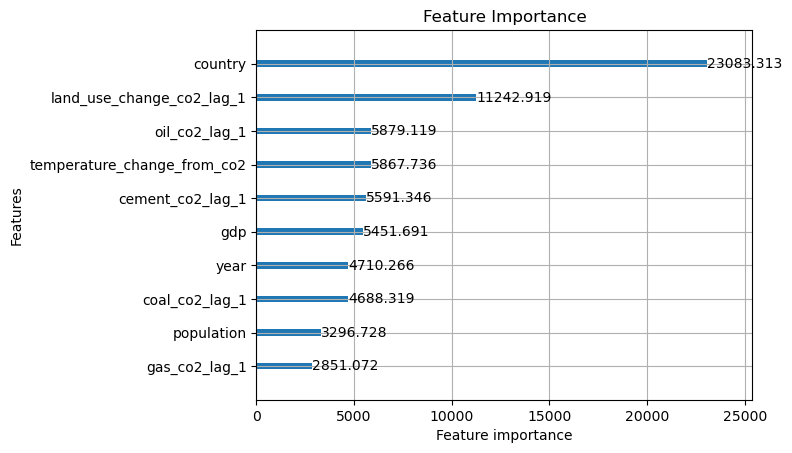

In [11]:
#Check feature importance
# Separate features and target
X_train = train_transformed.drop(columns=['co2'])
y_train = train_transformed['co2']

# Convert 'country' to a categorical feature
X_train['country'] = X_train['country'].astype('category')

# Fit the LightGBM model
best_model.fit(X_train, y_train, categorical_feature=['country'])

# Plot feature importance
plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance')
plt.show()

In [12]:
# Fit the model on the entire training data
forecast_model.fit(
    train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[],
    fitted=True
)

MLForecast(models=[LGBMRegressor], freq=1, lag_features=[], date_features=[], num_threads=2)

In [13]:
#TRAIN DATA
fitted_values = forecast_model.forecast_fitted_values()
results_train = fitted_values.rename(columns={'co2': 'co2_actual', 'LGBMRegressor': 'co2_predicted'})
results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

#predicted inverse transform
results_train_inverse = results_train.copy()

output_train_predicted = results_train['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data_train_predicted = data_preprocessor_lightgbm.inverse_transform_data(output_train_predicted, results_train.shape[0], train_df.shape[1]-2)
last_column_train_predicted = inverted_data_train_predicted[:, -1]
results_train_inverse['co2_predicted'] = last_column_train_predicted

output_train_actual = results_train['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data_train_actual = data_preprocessor_lightgbm.inverse_transform_data(output_train_actual, results_train.shape[0], train_df.shape[1]-2)
last_column_train_actual = inverted_data_train_actual[:, -1]
results_train_inverse['co2_actual'] = last_column_train_actual

results_train_inverse

,country,year,co2_actual,co2_predicted
0,Argentina,1929,242.878,282.475601
1,Argentina,1930,194.678,288.336538
2,Argentina,1931,163.215,186.127524
3,Argentina,1932,145.940,151.325379
4,Argentina,1933,134.144,132.972456
...,...,...,...,...
3139,Vietnam,2003,227.212,204.259806
3140,Vietnam,2004,246.341,216.150940
3141,Vietnam,2005,206.696,213.318482
3142,Vietnam,2006,189.254,195.918616


In [14]:
#TRAIN DATA
# Calculate the Mean Absolute Percentage Error (MAPE)
train_mape = mean_absolute_percentage_error(results_train_inverse['co2_actual'], results_train_inverse['co2_predicted'])
print(f"Train MAPE: {train_mape}")

Train MAPE: 0.11029647551111088


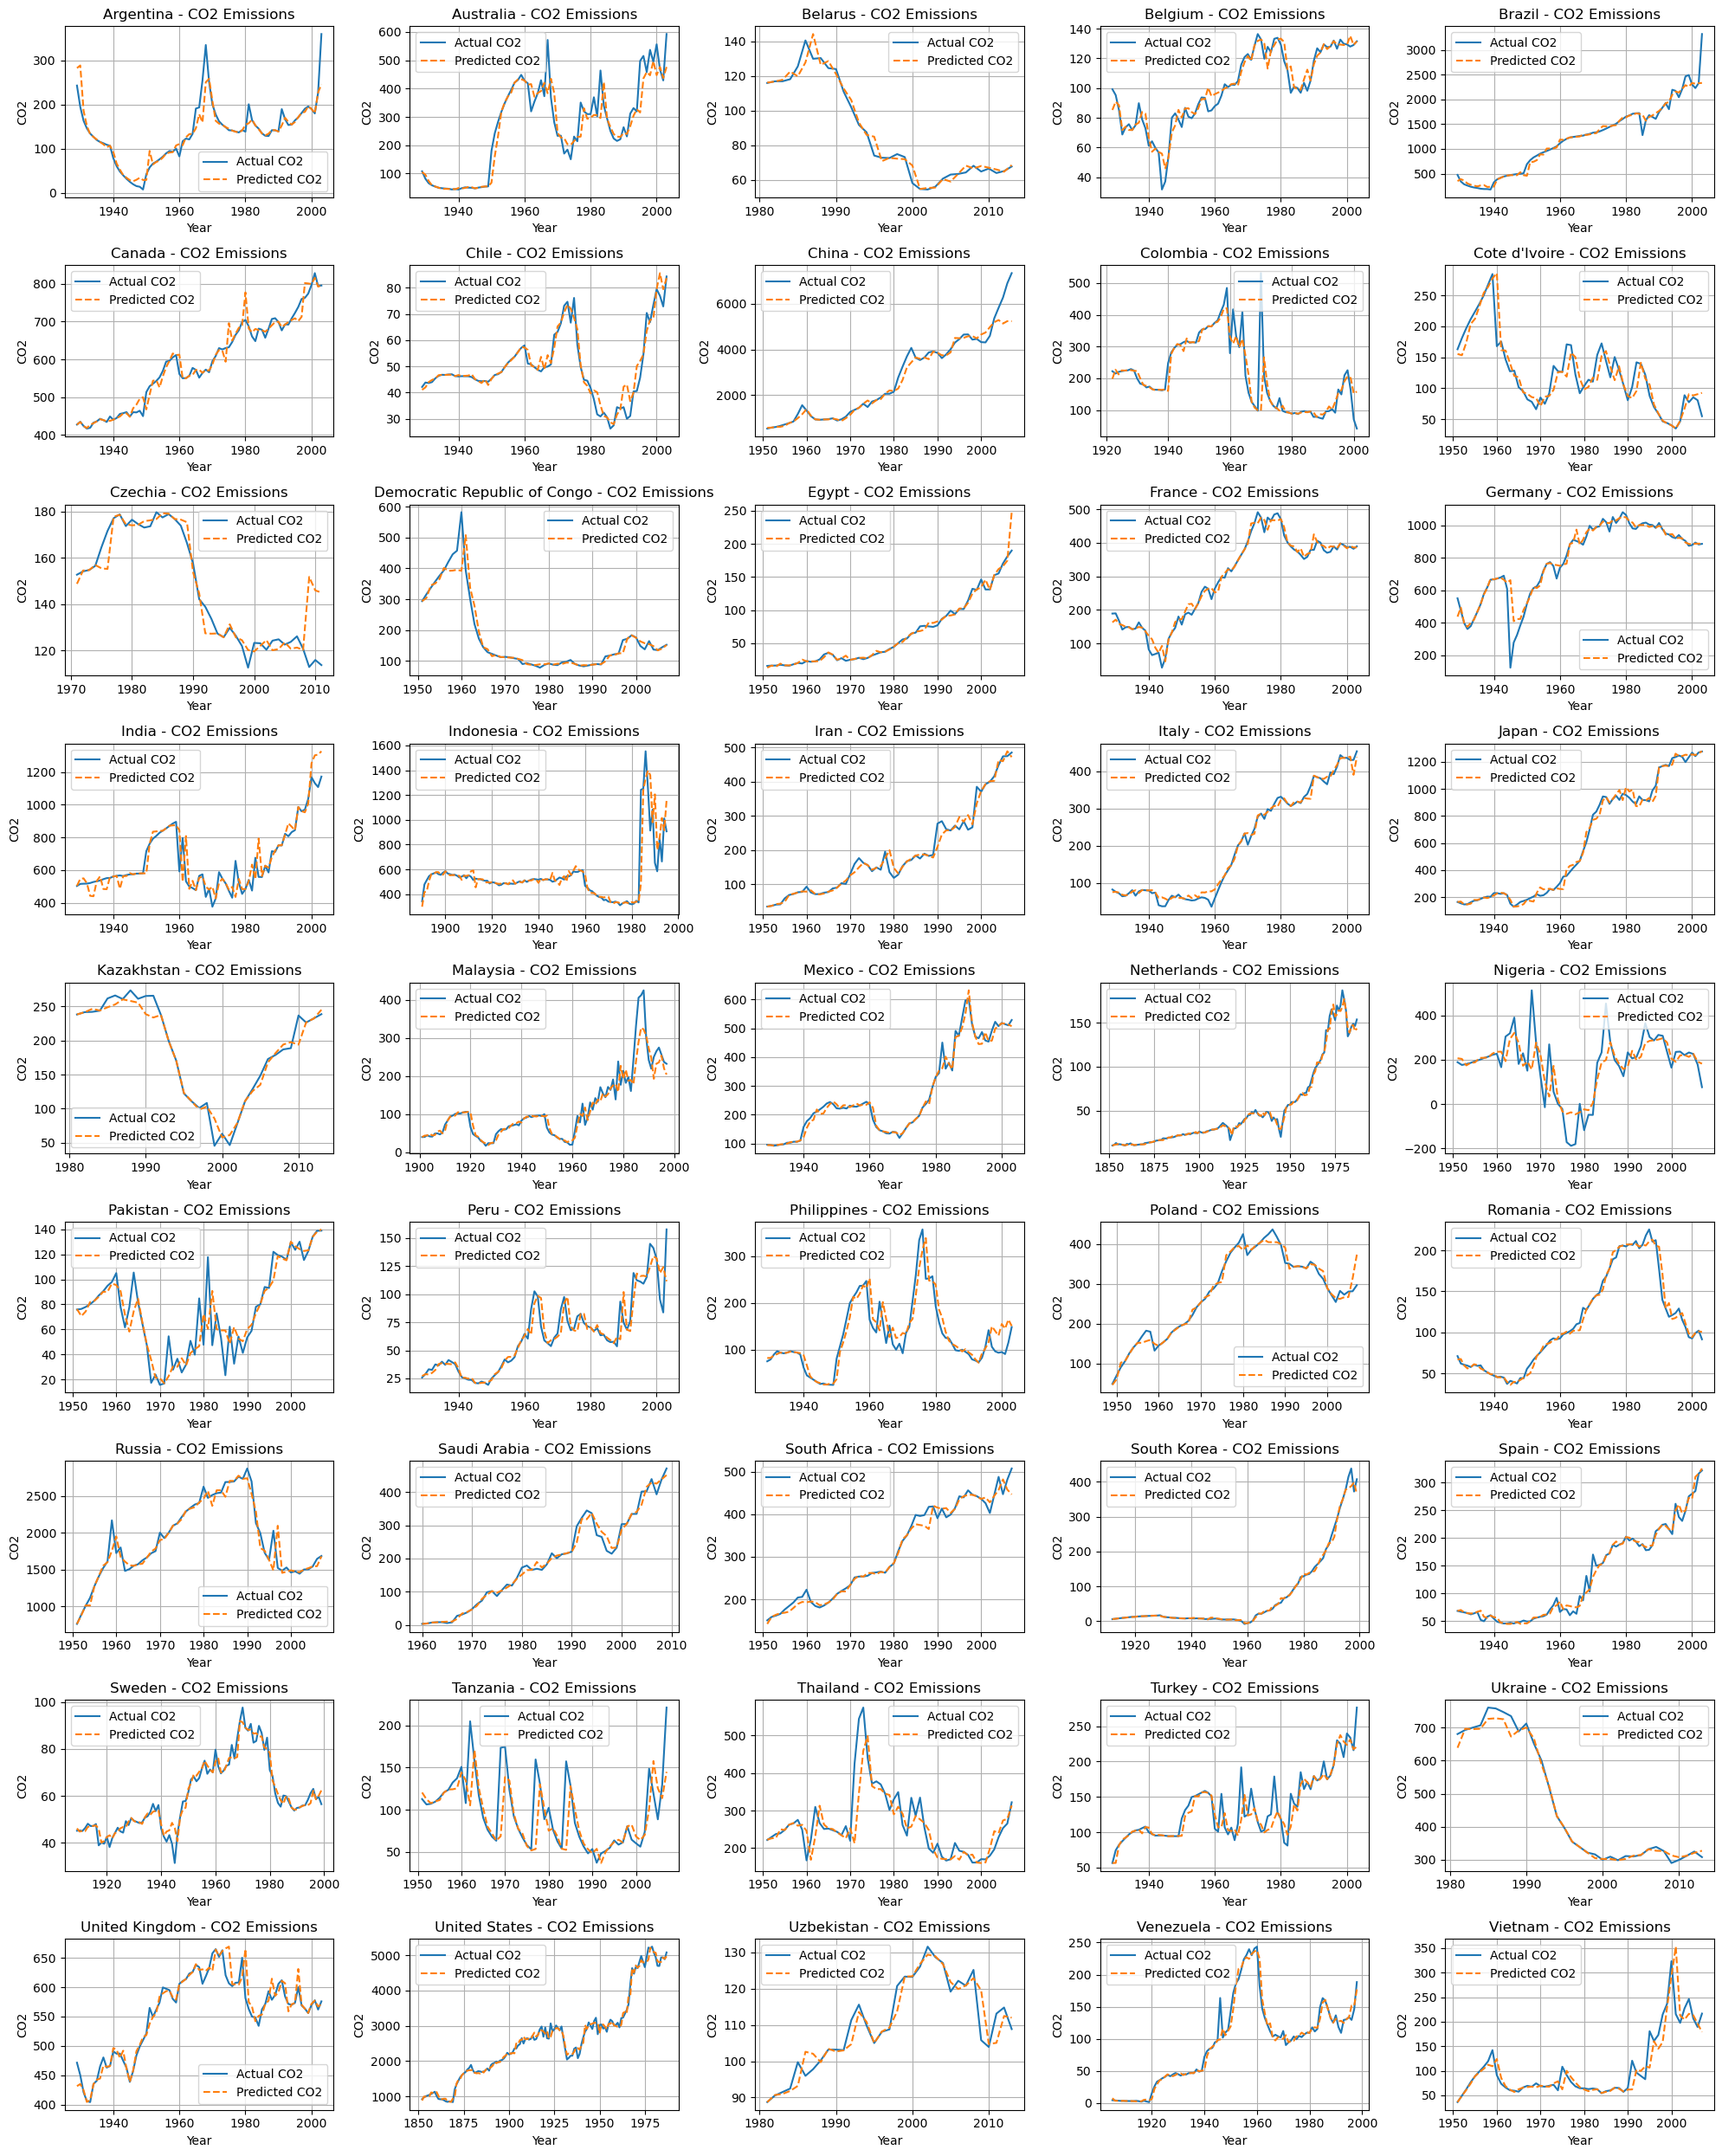

In [15]:
#TRAIN DATA

num_rows = 9
num_cols = 5
countries = results_train_inverse['country'].unique()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_train_inverse[results_train_inverse['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
all_predictions = []

for country in test_df['country'].unique():

    country_test_data = test_df[test_df['country'] == country].copy()
    horizon = country_test_data['year'].nunique()

    country_test_features = country_test_data.loc[:, country_test_data.columns != 'co2']

    country_predictions = forecast_model.predict(h=horizon, X_df=country_test_features, ids=[country])

    country_predictions['country'] = country
    country_predictions['year'] = country_test_data['year'].values[:len(country_predictions)]
    country_predictions = country_predictions.merge(
        country_test_data[['year', 'co2']],
        on='year',
        how='left'
    ).rename(columns={'co2': 'co2_actual'})

    all_predictions.append(country_predictions)

results_test = pd.concat(all_predictions).reset_index(drop=True).rename(columns={'LGBMRegressor': 'co2_predicted'})

#predicted inverse transform
results_test_inverse = results_test.copy()

output_test_predicted = results_test['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data_test_predicted = data_preprocessor_lightgbm.inverse_transform_data(output_test_predicted, results_test.shape[0], test_df.shape[1]-2)
last_column_test_predicted = inverted_data_test_predicted[:, -1]
results_test_inverse['co2_predicted'] = last_column_test_predicted

output_test_actual = results_test['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data_test_actual = data_preprocessor_lightgbm.inverse_transform_data(output_test_actual, results_test.shape[0], test_df.shape[1]-2)
last_column_test_actual = inverted_data_test_actual[:, -1]
results_test_inverse['co2_actual'] = last_column_test_actual

results_test_inverse

,country,year,co2_predicted,co2_actual
0,Argentina,2004,325.315385,450.881
1,Argentina,2005,375.977190,487.442
2,Argentina,2006,416.595506,505.851
3,Argentina,2007,415.307511,353.365
4,Argentina,2008,382.562915,293.438
...,...,...,...,...
805,Vietnam,2018,466.953456,504.751
806,Vietnam,2019,619.188533,589.843
807,Vietnam,2020,689.805484,613.079
808,Vietnam,2021,705.269246,605.475


In [17]:
#TRAIN DATA
# Calculate the Mean Absolute Percentage Error (MAPE)
mape_test = mean_absolute_percentage_error(results_test_inverse['co2_actual'], results_test_inverse['co2_predicted'])
print(f"Test MAPE: {mape_test}")

Test MAPE: 0.47428709694365107


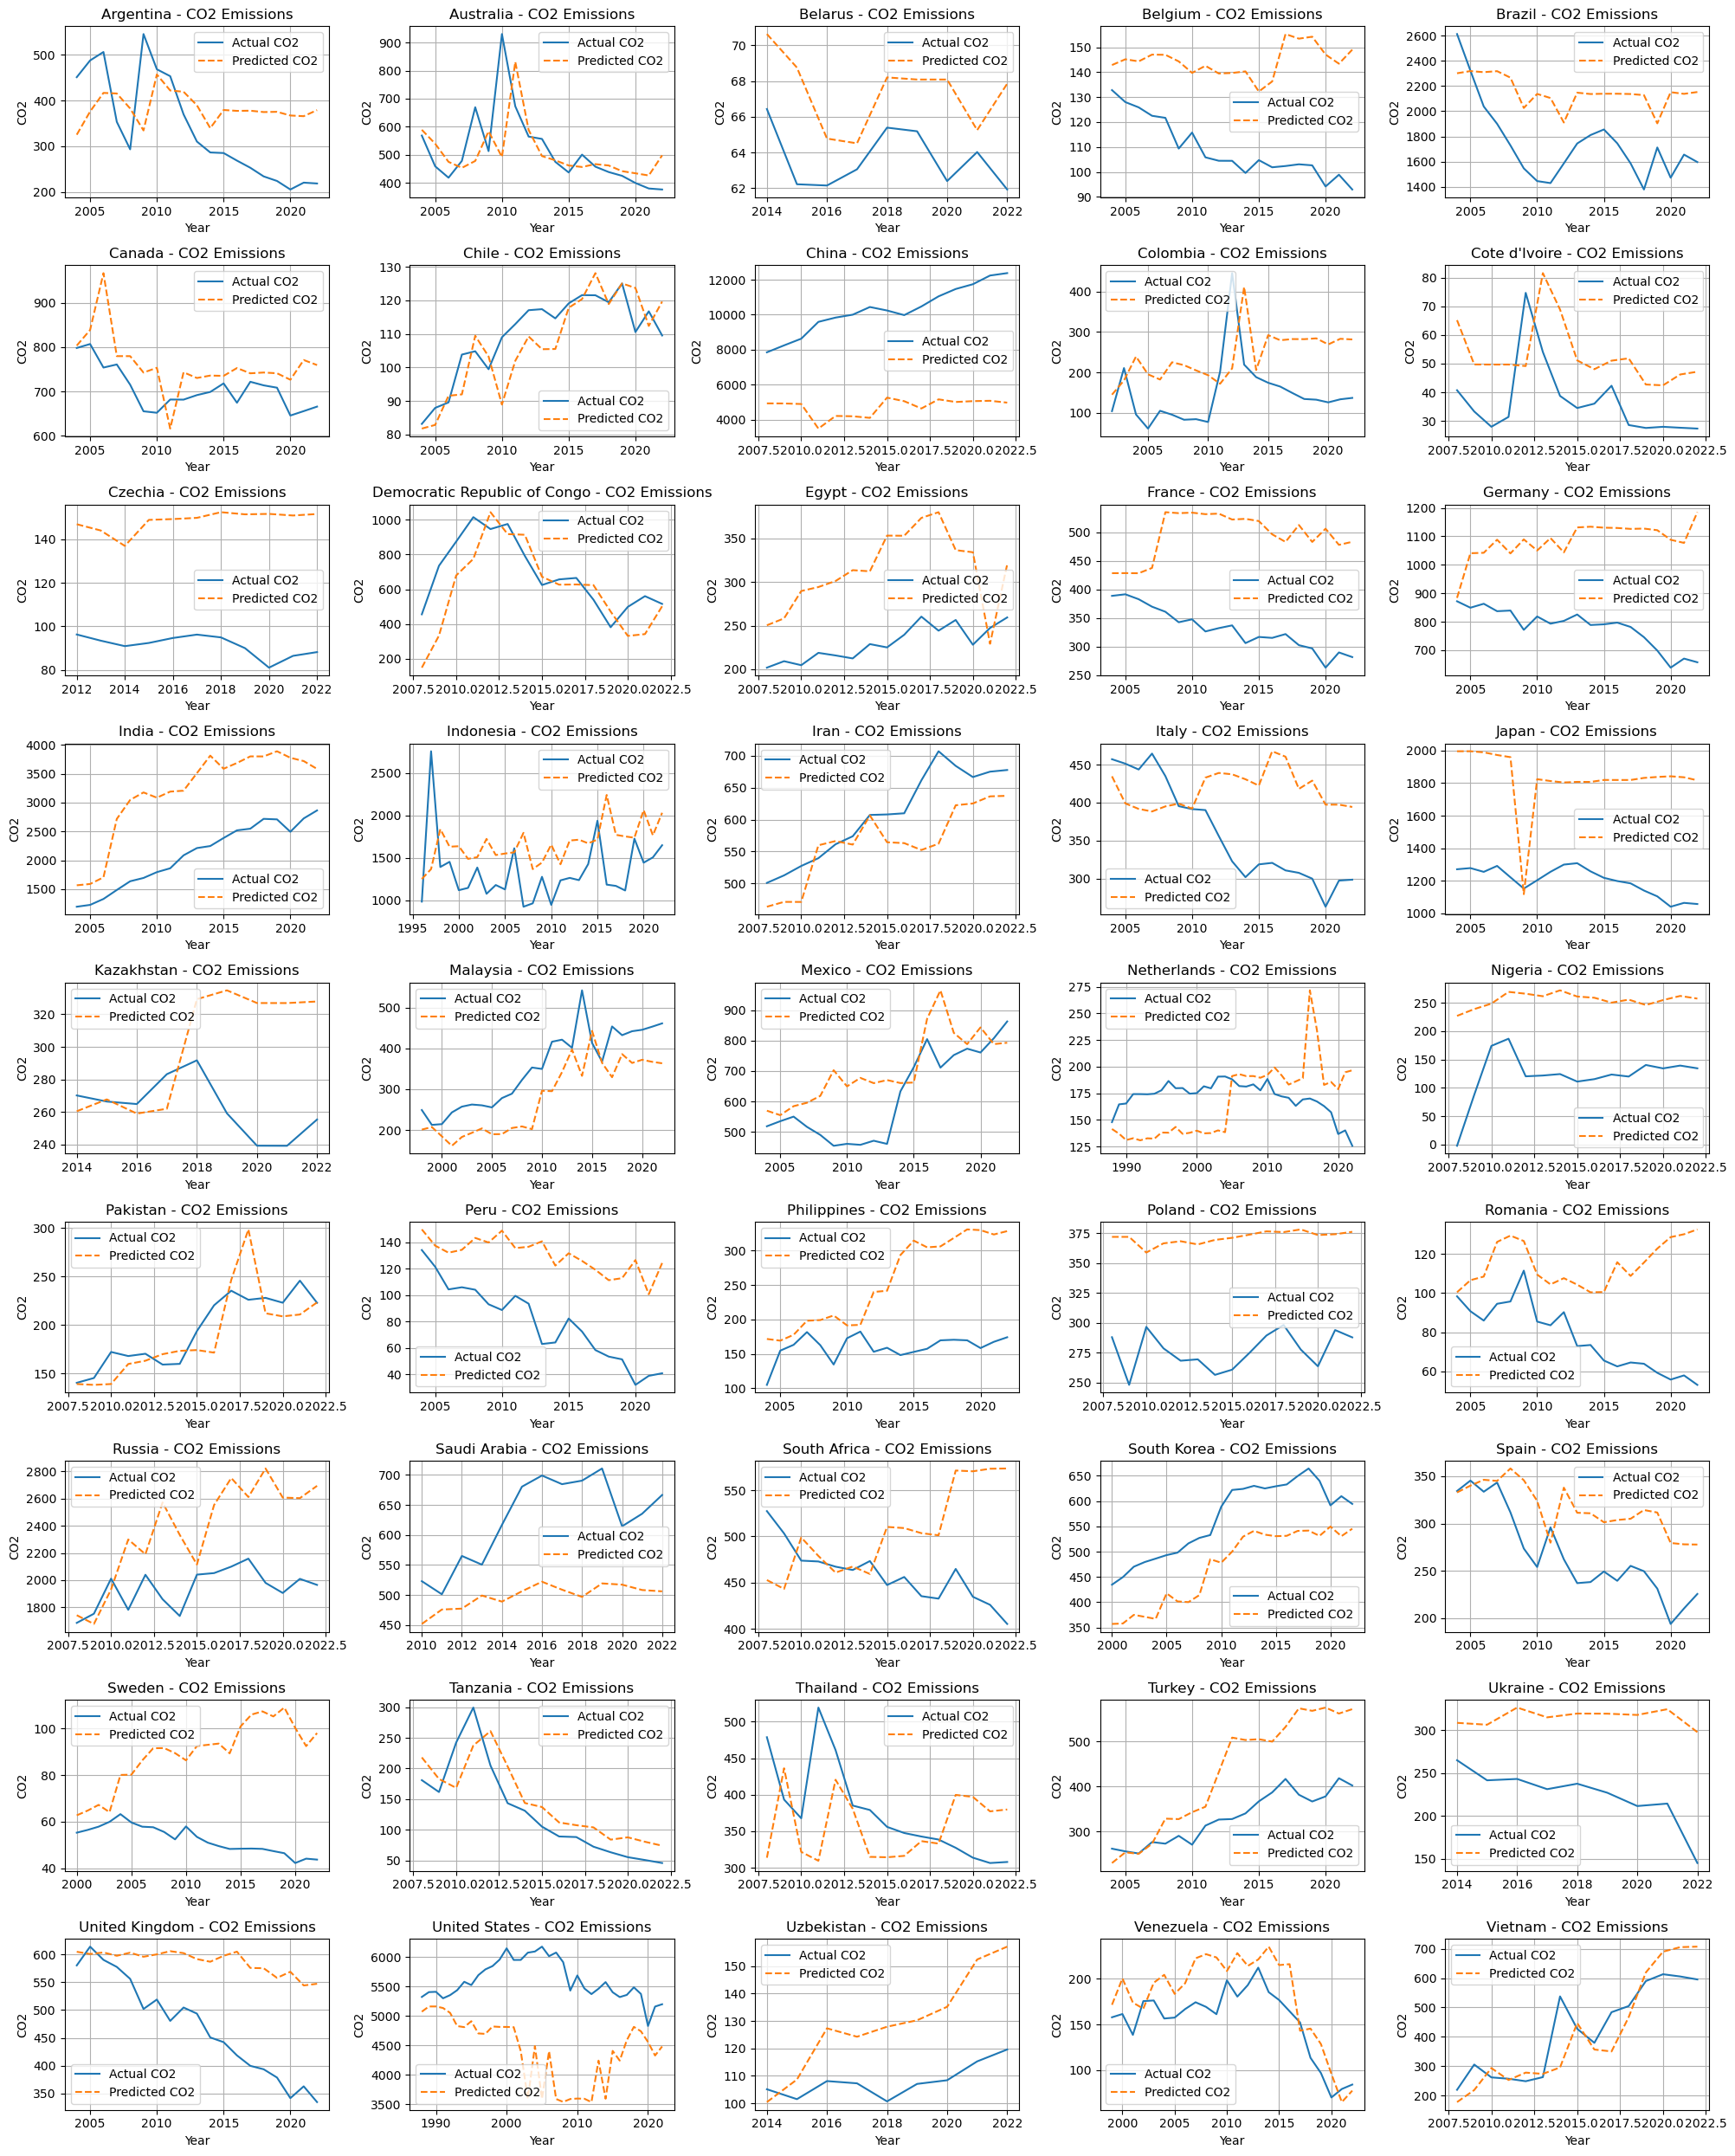

In [18]:
#TEST DATA
num_rows = 9
num_cols = 5
countries = results_test_inverse['country'].unique() 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    country_results = results_test_inverse[results_test_inverse['country'] == country]
    ax = axes[i]
    
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [19]:
# Custom R2 function
def custom_r2_score(y_actual, y_predicted):

    ss_total = np.sum((y_actual - np.mean(y_actual)) ** 2)
    ss_residual = np.sum((y_actual - y_predicted) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return max(0, r2)

In [20]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
# TRAIN SET
# Define metrics
metrics = {
    'MAPE': mean_absolute_percentage_error,
    'MAE': mean_absolute_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'R2': custom_r2_score
}

# Initialize DataFrame to store results
results_by_country = []

# Calculate metrics for each country
for country in results_train_inverse['country'].unique():
    country_df = results_train_inverse[results_train_inverse['country'] == country]
    actual_values = country_df['co2_actual']
    predicted_values = country_df['co2_predicted']
    country_metrics = {'country': country}
    
    for metric_name, metric_func in metrics.items():
        if len(actual_values) > 1:
            metric_value = metric_func(actual_values, predicted_values)
        else:
            metric_value = np.nan
        country_metrics[metric_name] = metric_value

    results_by_country.append(country_metrics)

# Create a DataFrame for results by country
results_by_country_df = pd.DataFrame(results_by_country)

# Calculate overall metrics
overall_actual = results_train_inverse['co2_actual']
overall_predicted = results_train_inverse['co2_predicted']
overall_metrics = {'country': 'Overall'}

for metric_name, metric_func in metrics.items():
    overall_metrics[metric_name] = metric_func(overall_actual, overall_predicted)

# Append overall metrics to the results DataFrame
overall_metrics_df = pd.DataFrame([overall_metrics])
final_results_df = pd.concat([results_by_country_df, overall_metrics_df], ignore_index=True)

# Display results
print("Metrics by country:")
print(results_by_country_df)
print("\nOverall metrics:")
print(overall_metrics_df)


Metrics by country:
                         country      MAPE         MAE        RMSE        R2
0                      Argentina  0.148186   12.149479   25.906635  0.848581
1                      Australia  0.099283   30.626638   54.618225  0.885060
2                        Belarus  0.035005    3.126480    4.825111  0.969287
3                        Belgium  0.055285    4.371761    6.629152  0.930690
4                         Brazil  0.071980   59.755836  139.184059  0.959411
5                         Canada  0.020167   12.094766   20.252428  0.968452
6                          Chile  0.047168    2.128435    3.584507  0.922755
7                          China  0.060463  210.902216  439.431810  0.940038
8                       Colombia  0.127520   21.597605   57.360819  0.743972
9                  Cote d'Ivoire  0.124637   14.994117   23.811835  0.828442
10                       Czechia  0.041623    5.366128   10.178527  0.822295
11  Democratic Republic of Congo  0.058615   14.435883  

In [21]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
# TRAIN SET
# Define metrics
metrics = {
    'MAPE': mean_absolute_percentage_error,
    'MAE': mean_absolute_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'R2': custom_r2_score
}

# Initialize DataFrame to store results
results_by_country = []

# Calculate metrics for each country
for country in results_test_inverse['country'].unique():
    country_df = results_test_inverse[results_test_inverse['country'] == country]
    actual_values = country_df['co2_actual']
    predicted_values = country_df['co2_predicted']
    country_metrics = {'country': country}
    
    for metric_name, metric_func in metrics.items():
        if len(actual_values) > 1:
            metric_value = metric_func(actual_values, predicted_values)
        else:
            metric_value = np.nan
        country_metrics[metric_name] = metric_value

    results_by_country.append(country_metrics)

# Create a DataFrame for results by country
results_by_country_df = pd.DataFrame(results_by_country)

# Calculate overall metrics
overall_actual = results_test_inverse['co2_actual']
overall_predicted = results_test_inverse['co2_predicted']
overall_metrics = {'country': 'Overall'}

for metric_name, metric_func in metrics.items():
    overall_metrics[metric_name] = metric_func(overall_actual, overall_predicted)

# Append overall metrics to the results DataFrame
overall_metrics_df = pd.DataFrame([overall_metrics])
final_results_df = pd.concat([results_by_country_df, overall_metrics_df], ignore_index=True)

# Display results
print("Metrics by country:")
print(results_by_country_df)
print("\nOverall metrics:")
print(overall_metrics_df)


Metrics by country:
                         country      MAPE          MAE         RMSE        R2
0                      Argentina  0.362424   105.107724   116.127577  0.000000
1                      Australia  0.130289    76.293850   124.488819  0.070892
2                        Belarus  0.058517     3.704668     4.141853  0.000000
3                        Belgium  0.339043    35.379345    37.765919  0.000000
4                         Brazil  0.270818   438.551622   476.626821  0.000000
5                         Canada  0.090687    62.702849    78.551675  0.000000
6                          Chile  0.060620     6.633475     8.465187  0.485907
7                          China  0.532119  5541.592528  5691.209944  0.000000
8                       Colombia  0.969431   119.380429   130.501113  0.000000
9                  Cote d'Ivoire  0.560671    19.561893    20.389928  0.000000
10                       Czechia  0.628529    57.015296    57.426100  0.000000
11  Democratic Republic of Congo

In [22]:
results_by_country_df[results_by_country_df['R2'] > 0].reset_index(drop = True)

,country,MAPE,MAE,RMSE,R2
0,Australia,0.130289,76.293850,124.488819,0.070892
1,Chile,0.060620,6.633475,8.465187,0.485907
2,Democratic Republic of Congo,0.220690,140.361609,177.537230,0.153823
3,Iran,0.074500,46.598145,59.016373,0.208757
4,Malaysia,0.213456,74.872687,87.780397,0.094586
5,Mexico,0.199326,106.597557,134.098221,0.106536
6,Pakistan,0.097428,19.901506,27.560479,0.376367
7,Tanzania,0.331359,35.988063,40.106706,0.703803
8,Venezuela,0.206670,30.607621,34.967092,0.134879
9,Vietnam,0.147025,65.203345,89.102244,0.623709
